# ZINBayes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from zinbayes.zinbayes import ZINBayes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

## Data set: Pollen et al, 2014
This data set contains 65 cells of four different types sequenced at low and high depth. We will use ZINBayes to visualize the cells in 2D with minimal technical bias.

We first visualize some properties of the data.

In [3]:
data_path = 'data/Pollen'
X = pd.read_csv(data_path + '/counts.csv').T
y = pd.read_csv(data_path + '/labels.csv')
b = pd.read_csv(data_path + '/batches.csv')


y = np.array(y)[:, 1]
y_names, y_id = np.unique(y, return_inverse=True)
celltypes = y_names

b = np.array(b)[:, 1]
b_names, b_id = np.unique(b, return_inverse=True)
coverage = b_names

b_onehot = OneHotEncoder().fit_transform(b_id.reshape(-1, 1)).toarray()

X = np.array(X)
gene_names = X[0, :]
X = np.array(X[1:, :], dtype=np.float32)
var_genes = np.var(X, axis=0)
X = X[:, np.argsort(var_genes)[-1000:]]

n_cells = X.shape[0]
n_genes = X.shape[1]
n_types = np.unique(y).size
n_batches = np.unique(b).size

print('Data shape:')
print('{} cells, {} genes\n'.format(X.shape[0], X.shape[1]))
print('{} cell types\n'.format(n_types))
print('{} experimental batches\n'.format(n_batches))
print('Percentage of zeros in the data set:')
print('{:.2f}%'.format(np.count_nonzero(X==0) / X.size * 100))

/home/pedro/IST/Thesis/ZINBayes/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Data shape:
130 cells, 1000 genes

4 cell types

2 experimental batches

Percentage of zeros in the data set:
32.84%


In [4]:
labels = y_id
clusters = y

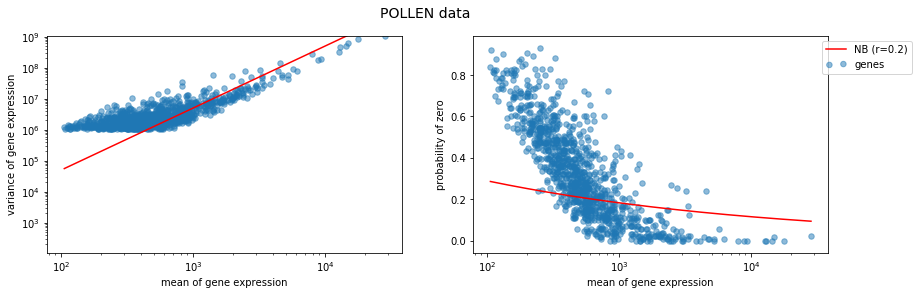

In [63]:
n_cells = X.shape[0]
n_genes = X.shape[1]

genecounts_mean = np.mean(X, axis=0)
genecounts_var = np.var(X, axis=0)

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
r_ = .2

s = 30
alpha = 0.5

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.scatter(genecounts_mean, genecounts_var, s=s, alpha=alpha)
# plt.plot(x, x, color='red')
plt.plot(x, x + 1/r_ * x**2, color='red')
plt.xlabel('mean of gene expression')
plt.ylabel('variance of gene expression')
plt.ylim(min(genecounts_mean.min(), genecounts_var.min()), max(genecounts_mean.max(), genecounts_var.max()))

# Dropout probability of each gene: number of cells with zero count of that gene / total number of cells
dropout_prob = np.sum(X==0, axis=0) / n_cells

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
poi_zeros = np.exp(-x)
nb_zeros = (r_/(x + r_))**r_

ax = plt.subplot(1, 2, 2)
plt.xscale('log')
plt.scatter(genecounts_mean, dropout_prob, label='genes', s=s, alpha=alpha)
# plt.plot(x, poi_zeros, color='red', label='Poisson')
plt.plot(x, nb_zeros, color='red', label='NB (r={})'.format(r_))
plt.xlabel('mean of gene expression')
plt.ylabel('probability of zero')
plt.legend(scatterpoints=2, frameon=True, bbox_to_anchor=[1.25, 1.0])

plt.suptitle('POLLEN data', fontsize=14)
# plt.savefig('PBMC_Poisson.pdf', dpi=300, bbox_inches='tight')
plt.show()


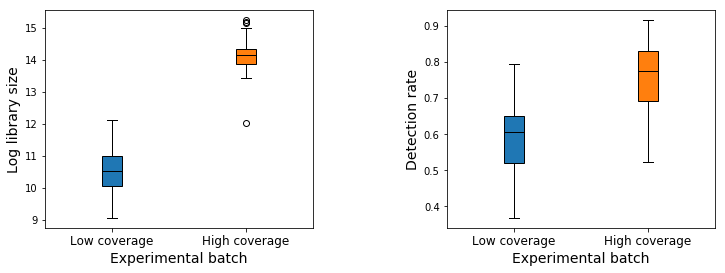

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)

bplot = plt.boxplot([np.log(np.sum(X[b_id==1], axis=1)), np.log(np.sum(X[b_id==0], axis=1))], patch_artist=True, )
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
    
    
ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[b_id==1] !=0, axis=1)/X.shape[1], np.sum(X[b_id==0]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)

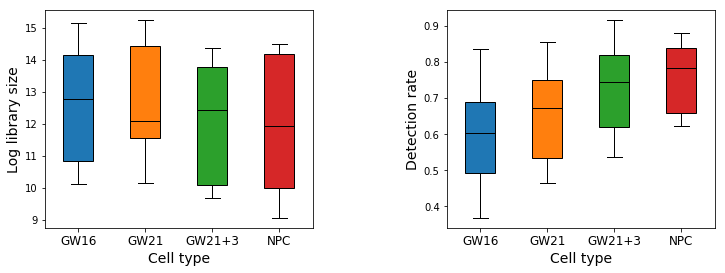

In [129]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
bplot = plt.boxplot([np.log(np.sum(X[labels==0], axis=1)), np.log(np.sum(X[labels==1], axis=1)), 
             np.log(np.sum(X[labels==2], axis=1)), np.log(np.sum(X[labels==3], axis=1))], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[labels==0] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==1] !=0, axis=1)/X.shape[1], np.sum(X[labels==2] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==3]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)

## Run ZINBayes without scalings, batch correction and zeros
Batch effects will dominate;

Within each batch, red and green differentiate but blue and orange overlap with everything.

Notice the scale of each latent component. It is very large because it is also modelling for size factors.

In [105]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1, 
                    scalings=False, zero_inflation=False, batch_correction=False)
z = zinbayes.fit_transform(X, max_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 25s | Loss: 5688.740


In [106]:
silhouette_score(z, labels)

-0.07172793

In [107]:
silhouette_score(z, b)

0.5334758

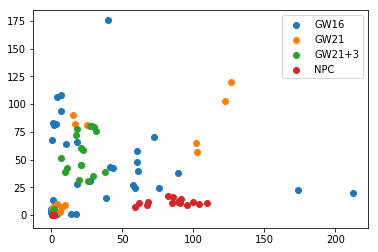

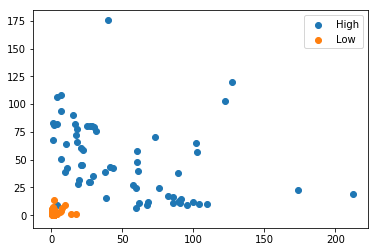

In [108]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run ZINBayes with scalings, without zeros and batch correction
Batches overlap due to scalings;

Red and green are separated but blue and orange overlap with green. This is 

In [113]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1, 
                   scalings=True, zero_inflation=False, batch_correction=False)
z = zinbayes.fit_transform(X, batch_idx=b_onehot, max_iter=1000)

Considering cell-specific scalings.
Considering gene-specific dispersion.
1000/1000 [100%] ██████████████████████████████ Elapsed: 35s | Loss: 5598.774


In [114]:
silhouette_score(z, labels)

0.1125801

In [115]:
silhouette_score(z, b)

-0.00220216

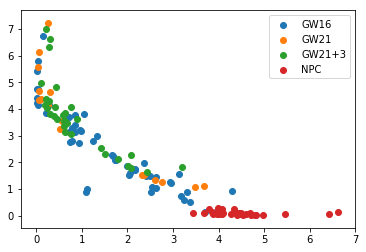

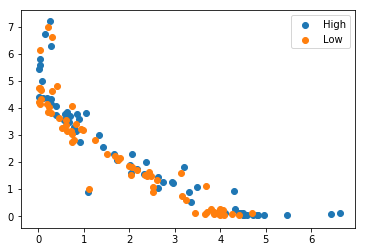

In [118]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run ZINBayes without batch annotations and scalings, with zero-inflation

In [130]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1,
                   scalings=False, zero_inflation=True, batch_correction=False)
z = zinbayes.fit_transform(X, max_iter=1000)

Considering zero-inflation.
1000/1000 [100%] ██████████████████████████████ Elapsed: 46s | Loss: 5752.313


In [131]:
silhouette_score(z, labels)

-0.084492624

In [132]:
silhouette_score(z, b)

0.5767138

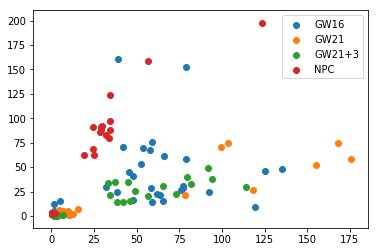

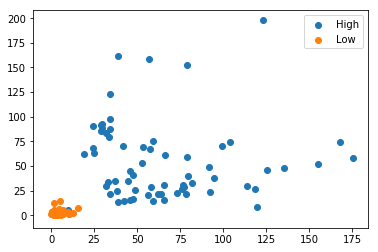

In [133]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run ZINBayes without batch annotations, with scalings and zero-inflation
Batches overlap due to scalings;

Blue and orange do not overlap with green due to zero model. This means that their dropout proportions were very similar and hid the remaining biological variations.

Maybe blue and orange are overlapping due to detection rate similarities. We do not have gene-specific scaling factors, but this would probably help.

In [149]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1,
                   scalings=True, zero_inflation=True, batch_correction=False)
z = zinbayes.fit_transform(X, max_iter=1000)

Considering zero-inflation.
Considering cell-specific scalings.
Considering gene-specific dispersion.
1000/1000 [100%] ██████████████████████████████ Elapsed: 57s | Loss: 5643.693


In [150]:
silhouette_score(z, labels)

0.17129022

In [151]:
silhouette_score(z, b)

0.037683085

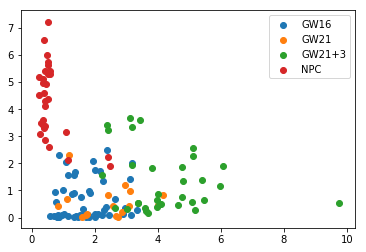

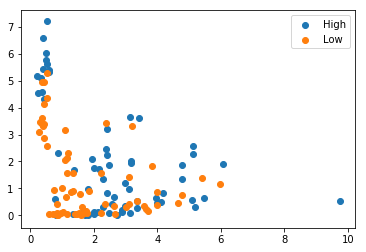

In [152]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

(array([336., 356., 179.,  78.,  29.,  11.,   8.,   1.,   0.,   2.]),
 array([ 0.02158112,  1.2057494 ,  2.3899176 ,  3.574086  ,  4.7582545 ,
         5.9424224 ,  7.1265907 ,  8.31076   ,  9.494927  , 10.679096  ,
        11.863264  ], dtype=float32),
 <a list of 10 Patch objects>)

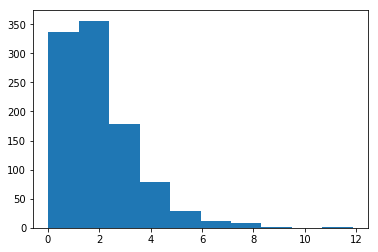

In [153]:
plt.hist(zinbayes.r.sample(1000).eval()[0])

(array([588., 265.,  55.,  35.,  22.,  16.,  12.,   3.,   2.,   2.]),
 array([0.02923846, 0.30516332, 0.5810882 , 0.857013  , 1.1329379 ,
        1.4088627 , 1.6847875 , 1.9607124 , 2.2366374 , 2.512562  ,
        2.788487  ], dtype=float32),
 <a list of 10 Patch objects>)

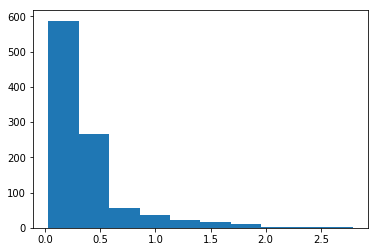

In [154]:
plt.hist(zinbayes.qr.sample(1000).eval()[0])

## Run ZINBayes without batch annotations, with scalings and zero-inflation and single dispersion parameter
Not much difference between using and not using gene-specific dispersion. It's good enough with a single one.

In [135]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1,
                   scalings=True, zero_inflation=True, batch_correction=False, gene_dispersion=False)
z = zinbayes.fit_transform(X, max_iter=1000)

Considering zero-inflation.
Considering cell-specific scalings.
Considering gene-specific dispersion.
1000/1000 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 5782.687


In [136]:
silhouette_score(z, labels)

0.13865758

In [137]:
silhouette_score(z, b_id)

0.032515917

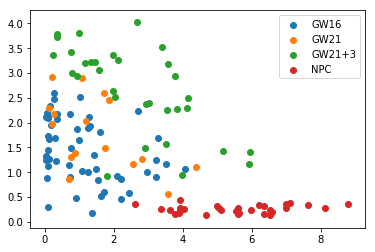

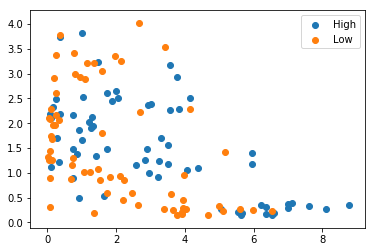

In [138]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run ZINBayes with batch annotations, scalings and zero-inflation and single dispersion parameter

In [143]:
zinbayes = ZINBayes(n_components=2, n_mc_samples=1,
                   scalings=True, zero_inflation=True, batch_correction=True, gene_dispersion=False)
z = zinbayes.fit_transform(X, batch_idx=b_onehot, max_iter=1000)

Considering zero-inflation.
Performing batch correction.
Considering cell-specific scalings.
Considering gene-specific dispersion.
1000/1000 [100%] ██████████████████████████████ Elapsed: 55s | Loss: 5801.413


In [144]:
silhouette_score(z, labels)

0.2241198

In [145]:
silhouette_score(z, b_id)

0.018370304

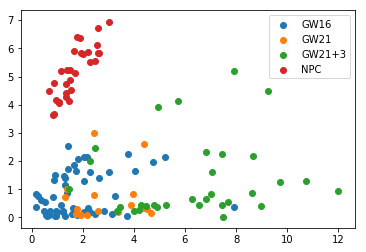

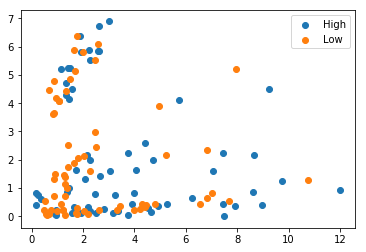

In [146]:
for c in range(len(y_names)):
    plt.scatter(z[labels==c, 0], z[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(z[b_id==c, 0], z[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

(array([221., 300., 195., 130.,  75.,  38.,  16.,  13.,   8.,   4.]),
 array([0.07484578, 0.89676577, 1.7186857 , 2.5406058 , 3.3625257 ,
        4.1844454 , 5.006366  , 5.8282857 , 6.6502056 , 7.4721255 ,
        8.294045  ], dtype=float32),
 <a list of 10 Patch objects>)

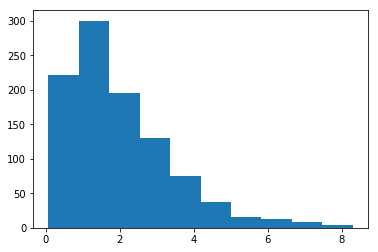

In [147]:
plt.hist(zinbayes.r.sample(1000).eval())

(array([ 15.,  56., 117., 219., 220., 189., 103.,  57.,  18.,   6.]),
 array([0.14765507, 0.1567225 , 0.16578992, 0.17485735, 0.18392478,
        0.19299221, 0.20205963, 0.21112706, 0.22019449, 0.2292619 ,
        0.23832934], dtype=float32),
 <a list of 10 Patch objects>)

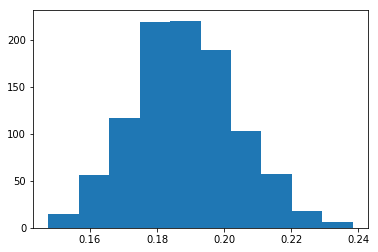

In [148]:
plt.hist(zinbayes.qr.sample(1000).eval())